In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [ ]:
import matplotlib as mpl

# Configuración de LaTeX para matplotlib
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "xelatex",        # change this if using xetex or lautex
    "text.usetex": False,                # use LaTeX to write all text
    "font.family": "sans-serif",
    # "font.serif": [],
    "font.sans-serif": ["DejaVu Sans"], # specify the sans-serif font
    "font.monospace": [],
    "axes.labelsize": 8,               # LaTeX default is 10pt font.
    "font.size": 0,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    # "figure.figsize": (3.15, 2.17),     # default fig size of 0.9 textwidth
    "pgf.preamble": r'\usepackage{amsmath},\usepackage{amsthm},\usepackage{amssymb},\usepackage{mathspec},\renewcommand{\familydefault}{\sfdefault},\usepackage[italic]{mathastext}'
    }
mpl.rcParams.update(pgf_with_latex)

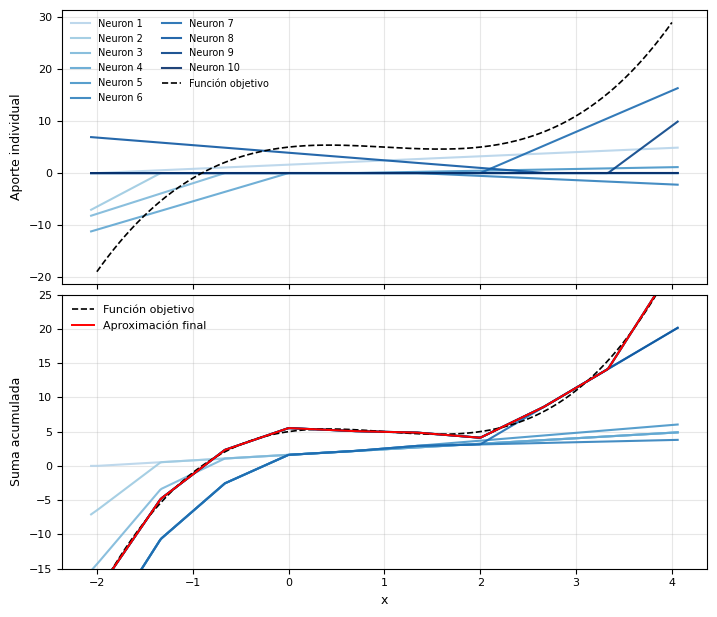

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ==== Datos ====
x_min, x_max = -2, 4
x = np.linspace(x_min, x_max, 200)
f = x**3 - 3*x**2 + 2*x + 5  # Función objetivo

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
f_tensor = torch.tensor(f, dtype=torch.float32).unsqueeze(1)

# ==== Modelo con quiebres fijos ====
class FixedBreakReLU(nn.Module):
    def __init__(self, n_neurons, fixed_breaks):
        super().__init__()
        self.n = n_neurons
        self.register_buffer("x_star", torch.tensor(fixed_breaks, dtype=torch.float32).unsqueeze(1))
        self.w1 = nn.Parameter(torch.randn(n_neurons, 1) * 0.5)
        self.w2 = nn.Parameter(torch.randn(n_neurons, 1) * 0.5)

    def forward(self, x):
        b1 = -self.w1 * self.x_star
        z = torch.relu(self.w1 * x.T + b1)        # (n_neurons, batch)
        out = (self.w2.T @ z).T                   # (batch, 1)
        return out, z

# ==== Configuración ====
n_neurons = 10
fixed_breaks = np.linspace(x_min, x_max, n_neurons)
model = FixedBreakReLU(n_neurons, fixed_breaks)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# ==== Entrenamiento ====
for epoch in range(5000):
    optimizer.zero_grad()
    out, _ = model(x_tensor)
    loss = loss_fn(out, f_tensor)
    loss.backward()
    optimizer.step()

# ==== Visualización ====
with torch.no_grad():
    margin = 0.01 * (x_max - x_min)
    x_plot_min, x_plot_max = x_min - margin, x_max + margin
    x_vals = np.linspace(x_plot_min, x_plot_max, 400)
    x_tensor_plot = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(1)

    b1 = -model.w1 * model.x_star
    z = torch.relu(model.w1 * x_tensor_plot.T + b1)   # (n_neurons, len(x_vals))
    y_pred, _ = model(x_tensor_plot)
    y_pred = y_pred.numpy()

# ==== Aportes individuales y acumulados ====
with torch.no_grad():
    contribs = (model.w2 * z).numpy()  # cada fila = contribución individual de la neurona i
    partial_sums = np.cumsum(contribs, axis=0)        # acumuladas progresivamente

# ==== Graficar ====
fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
colors = cm.Blues(np.linspace(0.3, 1.0, n_neurons))

# --- 1. Aportes individuales ---
for i in range(n_neurons):
    axes[0].plot(x_vals, contribs[i], color=colors[i], label=f'Neuron {i+1}', alpha=0.9)
axes[0].plot(x, f, 'k--', label='Función objetivo', linewidth=1.2)
axes[0].set_ylabel('Aporte individual', fontsize=9)
axes[0].legend(fontsize=7, ncol=2, frameon=False)
axes[0].grid(alpha=0.3)

# --- 2. Acumuladas progresivas ---
for i in range(n_neurons):
    axes[1].plot(x_vals, partial_sums[i], color=colors[i], alpha=0.9)
axes[1].plot(x, f, 'k--', linewidth=1.2, label='Función objetivo')
axes[1].plot(x_vals, y_pred, 'r', linewidth=1.4, label='Aproximación final')
axes[1].set_ylim([-15, 25])
axes[1].set_xlabel('x', fontsize=9)
axes[1].set_ylabel('Suma acumulada', fontsize=9)
axes[1].legend(fontsize=8, frameon=False)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Epoch 500, loss=3.3506e-01
Epoch 1000, loss=3.3506e-01
Epoch 1500, loss=3.3506e-01
Epoch 2000, loss=3.3506e-01
Epoch 2500, loss=3.3506e-01
Epoch 3000, loss=3.3506e-01


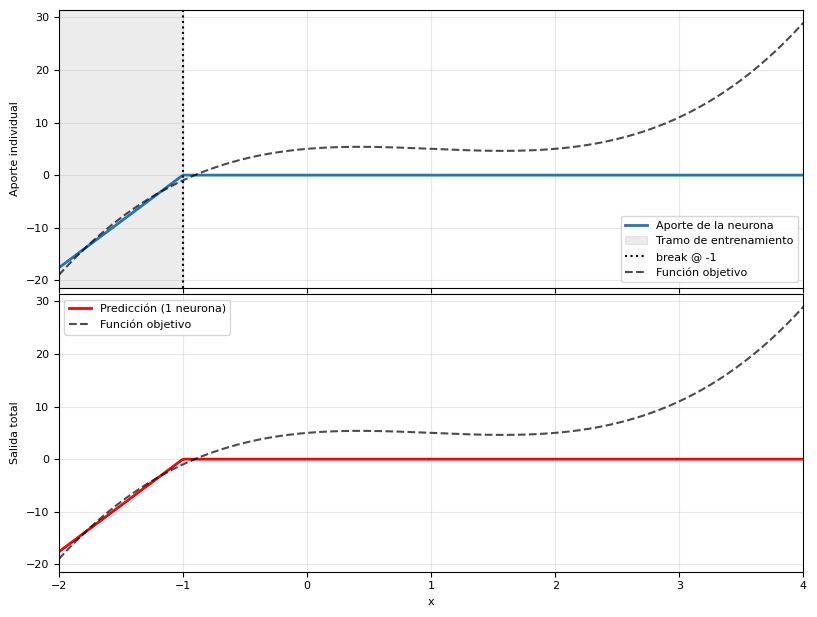

w1 = [[-4.6824603]]
w2 = [[-3.765424]]
x_star = [[-1.]]


In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ==== Datos ====
x_min, x_max = -2, 4
x = np.linspace(x_min, x_max, 400)
f = x**3 - 3*x**2 + 2*x + 5

x_tensor_full = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
f_tensor_full = torch.tensor(f, dtype=torch.float32).unsqueeze(1)

# Tramo local de entrenamiento
seg_left, seg_right = -2.0, -1.0
mask_local = (x >= seg_left) & (x <= seg_right)
x_local = x[mask_local]
f_local = f[mask_local]
x_tensor_local = torch.tensor(x_local, dtype=torch.float32).unsqueeze(1)
f_tensor_local = torch.tensor(f_local, dtype=torch.float32).unsqueeze(1)

# ==== Modelo ====
class FixedBreakReLU(nn.Module):
    def __init__(self, fixed_break):
        super().__init__()
        self.register_buffer("x_star", torch.tensor([[fixed_break]], dtype=torch.float32))
        # w1 negativo para activar hacia la izquierda
        self.w1 = nn.Parameter(torch.tensor([[-1.0]]))  
        self.w2 = nn.Parameter(torch.tensor([[0.1]]))

    def forward(self, x):
        b1 = -self.w1 * self.x_star
        z = torch.relu(self.w1 * x.T + b1)
        out = (self.w2.T @ z).T
        return out, z

# ==== Entrenamiento ====
model = FixedBreakReLU(fixed_break=-1.0)
optimizer = optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.MSELoss()

for epoch in range(3000):
    optimizer.zero_grad()
    out_local, _ = model(x_tensor_local)
    loss = loss_fn(out_local, f_tensor_local)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}, loss={loss.item():.4e}")

# ==== Evaluación ====
with torch.no_grad():
    out_full, z_full = model(x_tensor_full)
    contrib = (model.w2 * z_full).squeeze().numpy()
    y_pred_full = out_full.squeeze().numpy()

# ==== Graficar ====
fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)

axes[0].plot(x, contrib, color='C0', lw=2, label='Aporte de la neurona')
axes[0].axvspan(seg_left, seg_right, color='gray', alpha=0.15, label='Tramo de entrenamiento')
axes[0].axvline(-1, color='k', linestyle=':', label='break @ -1')
axes[0].plot(x, f, 'k--', alpha=0.7, label='Función objetivo')
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.3)
axes[0].set_ylabel('Aporte individual')

axes[1].plot(x, y_pred_full, 'r', lw=2, label='Predicción (1 neurona)')
axes[1].plot(x, f, 'k--', alpha=0.7, label='Función objetivo')
axes[1].set_xlim(x_min, x_max)
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)
axes[1].set_xlabel('x')
axes[1].set_ylabel('Salida total')

plt.tight_layout()
plt.show()

print("w1 =", model.w1.detach().numpy())
print("w2 =", model.w2.detach().numpy())
print("x_star =", model.x_star.detach().numpy())


Epoch 500, loss=1.2455e-01
Epoch 1000, loss=1.2455e-01
Epoch 1500, loss=1.2455e-01
Epoch 2000, loss=1.2455e-01
Epoch 2500, loss=1.2455e-01
Epoch 3000, loss=1.2455e-01


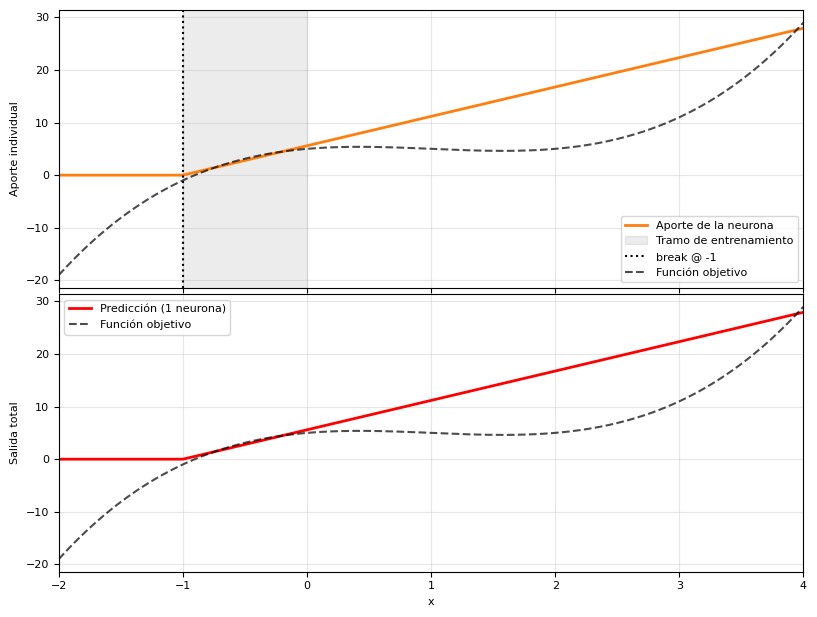

w1 = [[2.9124625]]
w2 = [[1.9181385]]
x_star = [[-1.]]


In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ==== Datos ====
x_min, x_max = -2, 4
x = np.linspace(x_min, x_max, 400)
f = x**3 - 3*x**2 + 2*x + 5

x_tensor_full = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
f_tensor_full = torch.tensor(f, dtype=torch.float32).unsqueeze(1)

# Tramo local de entrenamiento: ahora de -1 a 0
seg_left, seg_right = -1.0, 0.0
mask_local = (x >= seg_left) & (x <= seg_right)
x_local = x[mask_local]
f_local = f[mask_local]
x_tensor_local = torch.tensor(x_local, dtype=torch.float32).unsqueeze(1)
f_tensor_local = torch.tensor(f_local, dtype=torch.float32).unsqueeze(1)

# ==== Modelo ====
class FixedBreakReLU(nn.Module):
    def __init__(self, fixed_break):
        super().__init__()
        self.register_buffer("x_star", torch.tensor([[fixed_break]], dtype=torch.float32))
        # w1 positivo para activar hacia la derecha (ya que el tramo está a la derecha del break)
        self.w1 = nn.Parameter(torch.tensor([[1.0]]))
        self.w2 = nn.Parameter(torch.tensor([[0.1]]))

    def forward(self, x):
        b1 = -self.w1 * self.x_star
        z = torch.relu(self.w1 * x.T + b1)
        out = (self.w2.T @ z).T
        return out, z

# ==== Entrenamiento ====
model = FixedBreakReLU(fixed_break=-1.0)  # break sigue siendo -1
optimizer = optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.MSELoss()

for epoch in range(3000):
    optimizer.zero_grad()
    out_local, _ = model(x_tensor_local)
    loss = loss_fn(out_local, f_tensor_local)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}, loss={loss.item():.4e}")

# ==== Evaluación ====
with torch.no_grad():
    out_full, z_full = model(x_tensor_full)
    contrib = (model.w2 * z_full).squeeze().numpy()
    y_pred_full = out_full.squeeze().numpy()

# ==== Graficar ====
fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)

axes[0].plot(x, contrib, color='C1', lw=2, label='Aporte de la neurona')
axes[0].axvspan(seg_left, seg_right, color='gray', alpha=0.15, label='Tramo de entrenamiento')
axes[0].axvline(-1, color='k', linestyle=':', label='break @ -1')
axes[0].plot(x, f, 'k--', alpha=0.7, label='Función objetivo')
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.3)
axes[0].set_ylabel('Aporte individual')

axes[1].plot(x, y_pred_full, 'r', lw=2, label='Predicción (1 neurona)')
axes[1].plot(x, f, 'k--', alpha=0.7, label='Función objetivo')
axes[1].set_xlim(x_min, x_max)
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)
axes[1].set_xlabel('x')
axes[1].set_ylabel('Salida total')

plt.tight_layout()
plt.show()

print("w1 =", model.w1.detach().numpy())
print("w2 =", model.w2.detach().numpy())
print("x_star =", model.x_star.detach().numpy())


Tramo 1 [-2,-1] - epoch 1500, loss=3.3506e-01
Tramo 1 [-2,-1] - epoch 3000, loss=3.3506e-01
Tramo 1 [-2,-1] — Pendiente efectiva = 17.6314


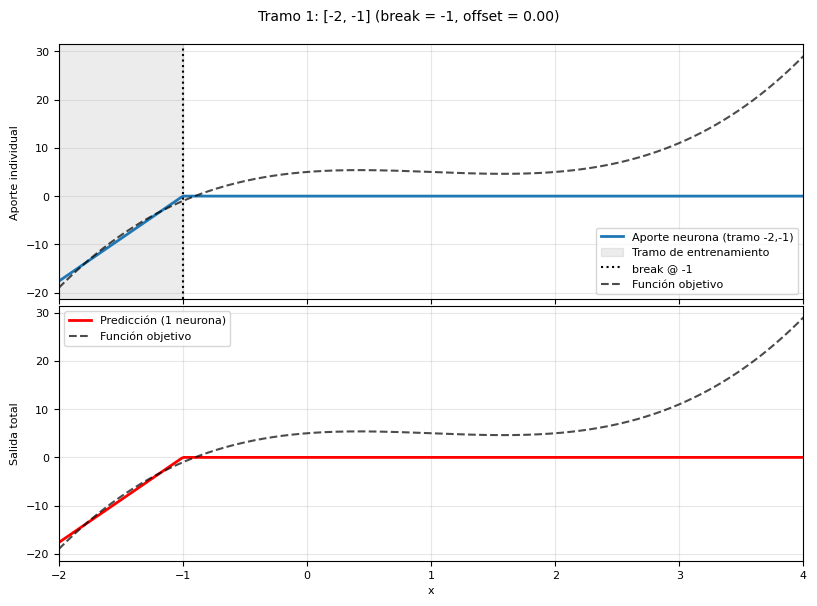

Tramo 1 [-2,-1] — w1 = 4.6825, w2 = -3.7654
Altura final del tramo: 0.0000

Tramo 2 [-1,0] - epoch 1500, loss=1.2455e-01
Tramo 2 [-1,0] - epoch 3000, loss=1.2455e-01
Tramo 2 [-1,0] — Pendiente efectiva = 5.5865


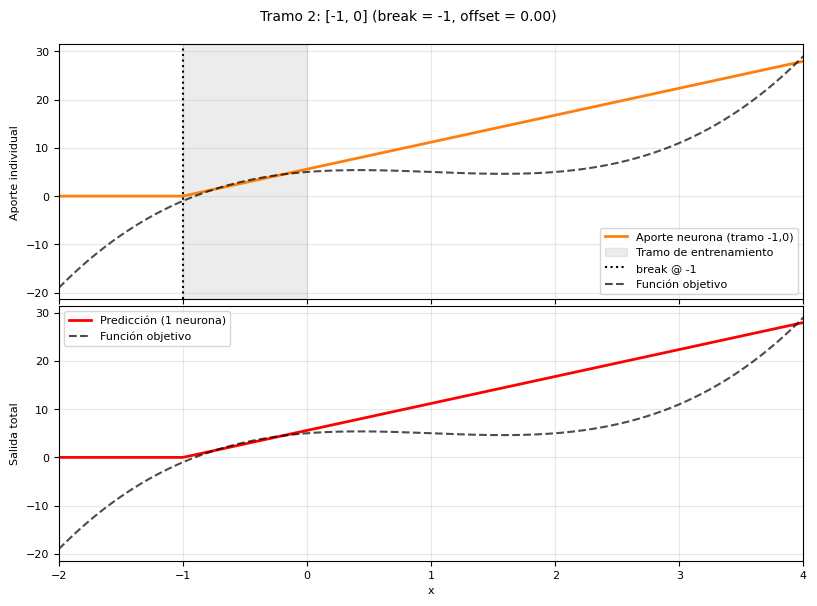

Tramo 2 [-1,0] — w1 = 2.9125, w2 = 1.9181
Altura final del tramo: 5.5865

Tramo 3 [0,1] - epoch 1500, loss=3.5752e-02
Tramo 3 [0,1] - epoch 3000, loss=3.5752e-02
Tramo 3 [0,1] — Pendiente efectiva = -0.5297


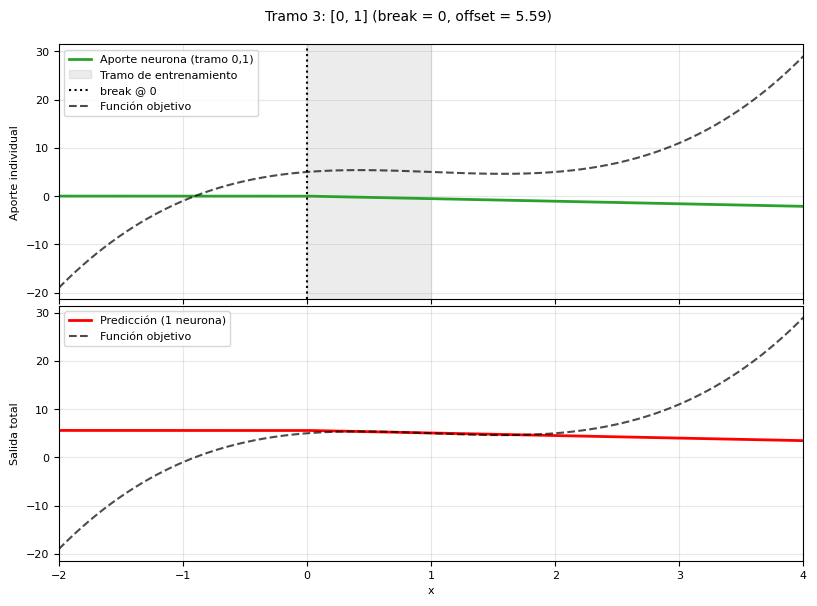

Tramo 3 [0,1] — w1 = 0.9108, w2 = -0.5816
Altura final del tramo: 5.0528

Tramo 4 [1,2] - epoch 1500, loss=2.9986e-02
Tramo 4 [1,2] - epoch 3000, loss=2.9986e-02
Tramo 4 [1,2] — Pendiente efectiva = -0.4697


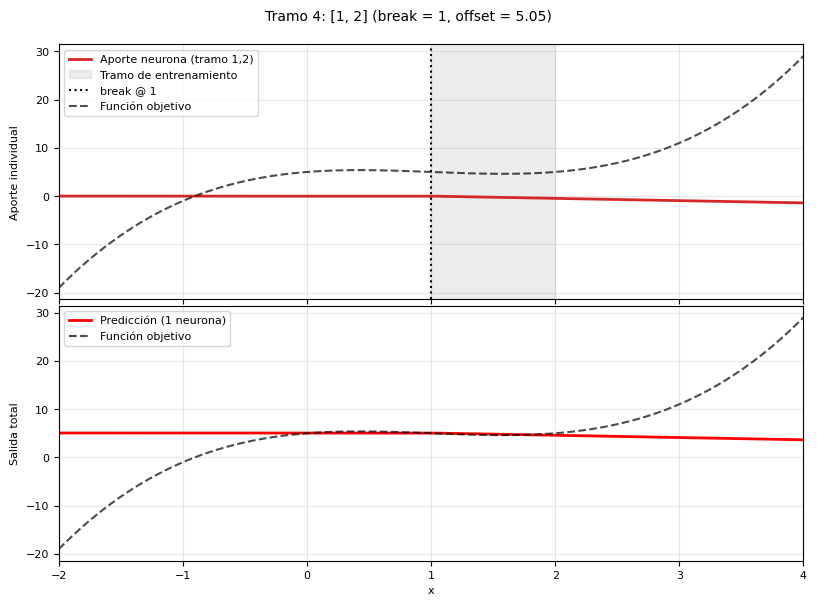

Tramo 4 [1,2] — w1 = 0.8529, w2 = -0.5507
Altura final del tramo: 4.5832

Tramo 5 [2,3] - epoch 1500, loss=1.3316e-01
Tramo 5 [2,3] - epoch 3000, loss=1.3316e-01
Tramo 5 [2,3] — Pendiente efectiva = 5.4751


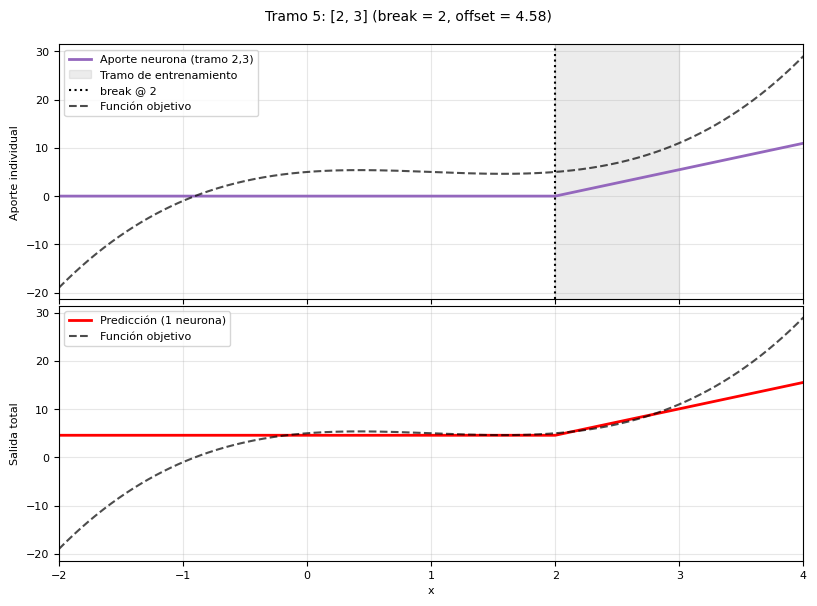

Tramo 5 [2,3] — w1 = 2.8871, w2 = 1.8964
Altura final del tramo: 10.0994

Tramo 6 [3,4] - epoch 1500, loss=3.4844e-01
Tramo 6 [3,4] - epoch 3000, loss=3.4844e-01
Tramo 6 [3,4] — Pendiente efectiva = 17.4835


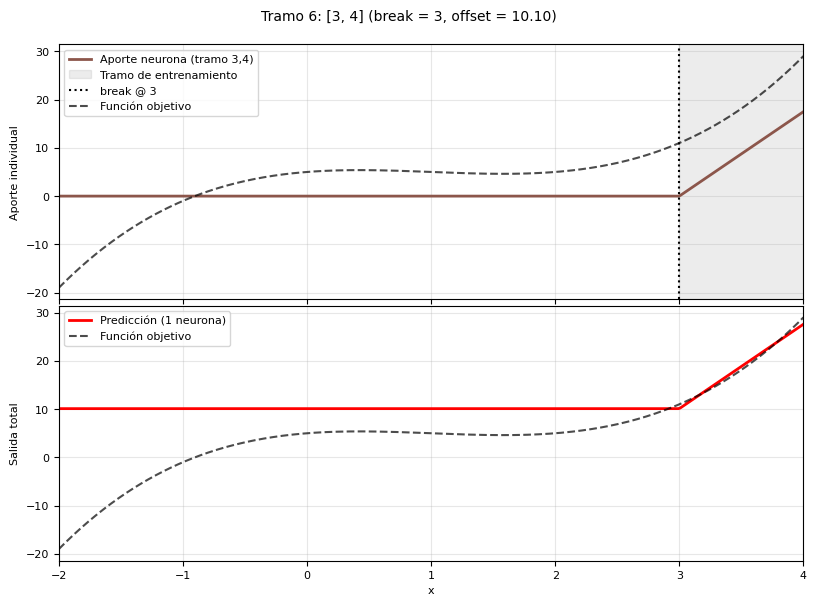

Tramo 6 [3,4] — w1 = 4.8260, w2 = 3.6228
Altura final del tramo: 27.5829



In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ==== Datos (dominio global) ====
x_min, x_max = -2, 4
x = np.linspace(x_min, x_max, 400)
f = x**3 - 3*x**2 + 2*x + 5

x_tensor_full = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
f_tensor_full = torch.tensor(f, dtype=torch.float32).unsqueeze(1)

# ==== Modelo (una sola neurona, break fijo) ====
class FixedBreakReLU(nn.Module):
    def __init__(self, fixed_break, w1_init=1.0, w2_init=0.1, activate_left=False, y_offset=0.0):
        super().__init__()
        self.register_buffer("x_star", torch.tensor([[fixed_break]], dtype=torch.float32))
        self.w1 = nn.Parameter(torch.tensor([[w1_init]], dtype=torch.float32))
        self.w2 = nn.Parameter(torch.tensor([[w2_init]], dtype=torch.float32))
        self.y_offset = y_offset
        self.activate_left = activate_left  # activa hacia la izquierda si True

    def forward(self, x):
        if self.activate_left:
            # activa hacia la izquierda del break
            z = torch.relu(-self.w1 * x.T + self.w1 * self.x_star)
        else:
            # activa hacia la derecha del break
            b1 = -self.w1 * self.x_star
            z = torch.relu(self.w1 * x.T + b1)
        out = (self.w2.T @ z).T + self.y_offset  # se suma la altura previa
        return out, z

# ==== Lista de tramos (6 tramos cubriendo [-2,4]) ====
segments = [(-2, -1), (-1, 0), (0, 1), (1, 2), (2, 3), (3, 4)]

# ==== Entrenamiento por tramo (con continuidad vertical) ====
prev_y_at_right = 0.0  # altura final del tramo anterior

for i, (seg_left, seg_right) in enumerate(segments):
    # Datos locales
    mask_local = (x >= seg_left) & (x <= seg_right)
    x_local = x[mask_local]
    f_local = f[mask_local]
    x_tensor_local = torch.tensor(x_local, dtype=torch.float32).unsqueeze(1)
    f_tensor_local = torch.tensor(f_local, dtype=torch.float32).unsqueeze(1)

    # ==== Configuración del break y dirección de activación ====
    if i == 0:
        # Primer tramo: break a la derecha, activa hacia la izquierda
        fixed_break = seg_right
        activate_left = True
    else:
        # Resto de tramos: break a la izquierda, activa hacia la derecha
        fixed_break = seg_left
        activate_left = False

    # Crear modelo con offset del tramo anterior
    model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=prev_y_at_right)

    optimizer = optim.Adam(model.parameters(), lr=0.05)
    loss_fn = nn.MSELoss()

    # ==== Entrenamiento ====
    for epoch in range(3000):
        optimizer.zero_grad()
        out_local, _ = model(x_tensor_local)
        loss = loss_fn(out_local, f_tensor_local)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 1500 == 0:
            print(f"Tramo {i+1} [{seg_left},{seg_right}] - epoch {epoch+1}, loss={loss.item():.4e}")

    # ==== Evaluación ====
    with torch.no_grad():
        out_full, z_full = model(x_tensor_full)
        contrib = (model.w2 * z_full).squeeze().numpy()
        y_pred_full = out_full.squeeze().numpy()

        # altura final del tramo actual (para continuidad)
        idx_right = np.argmin(np.abs(x - seg_right))
        prev_y_at_right = y_pred_full[idx_right]

    # ==== Evaluación ====
    with torch.no_grad():
        out_full, z_full = model(x_tensor_full)
        contrib = (model.w2 * z_full).squeeze().numpy()
        y_pred_full = out_full.squeeze().numpy()

        # altura final del tramo actual (para continuidad)
        idx_right = np.argmin(np.abs(x - seg_right))
        prev_y_at_right = y_pred_full[idx_right]

        # ==== Cálculo de la pendiente ====
        if activate_left:
            slope = - (model.w1.detach().item() * model.w2.detach().item())
        else:
            slope = model.w1.detach().item() * model.w2.detach().item()

        print(f"Tramo {i+1} [{seg_left},{seg_right}] — Pendiente efectiva = {slope:.4f}")

    # ==== Gráficas ====
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    axes[0].plot(x, contrib, color=f'C{i}', lw=2, label=f'Aporte neurona (tramo {seg_left},{seg_right})')
    axes[0].axvspan(seg_left, seg_right, color='gray', alpha=0.15, label='Tramo de entrenamiento')
    axes[0].axvline(fixed_break, color='k', linestyle=':', label=f'break @ {fixed_break}')
    axes[0].plot(x, f, 'k--', alpha=0.7, label='Función objetivo')
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3)
    axes[0].set_ylabel('Aporte individual')

    axes[1].plot(x, y_pred_full, 'r', lw=2, label='Predicción (1 neurona)')
    axes[1].plot(x, f, 'k--', alpha=0.7, label='Función objetivo')
    axes[1].set_xlim(x_min, x_max)
    axes[1].legend(fontsize=8)
    axes[1].grid(alpha=0.3)
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('Salida total')

    plt.suptitle(f"Tramo {i+1}: [{seg_left}, {seg_right}] (break = {fixed_break}, offset = {model.y_offset:.2f})", fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"Tramo {i+1} [{seg_left},{seg_right}] — w1 = {model.w1.detach().numpy().item():.4f}, w2 = {model.w2.detach().numpy().item():.4f}")
    print(f"Altura final del tramo: {prev_y_at_right:.4f}")
    print()


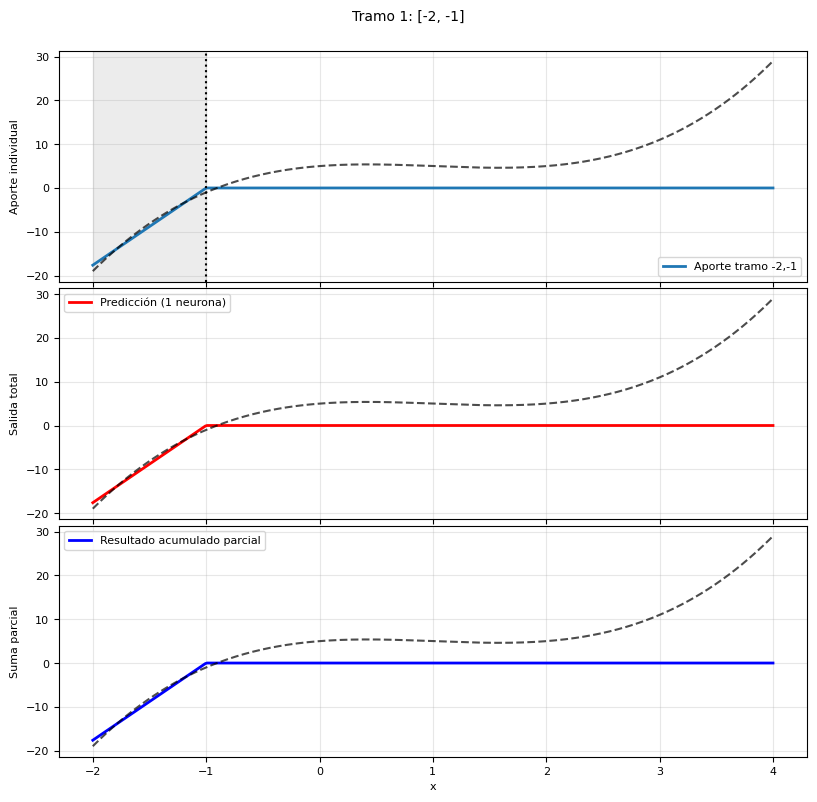

Tramo 1 [-2,-1] — w entrenado = -17.6314
Altura final del tramo: 0.0000



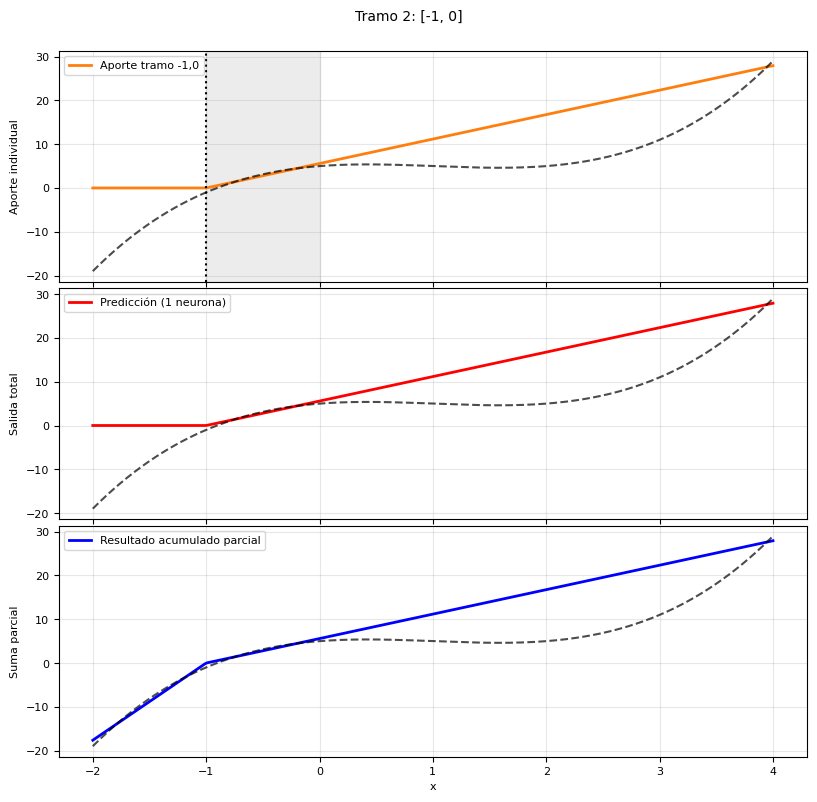

Tramo 2 [-1,0] — w entrenado = 5.5865
Altura final del tramo: 5.5865



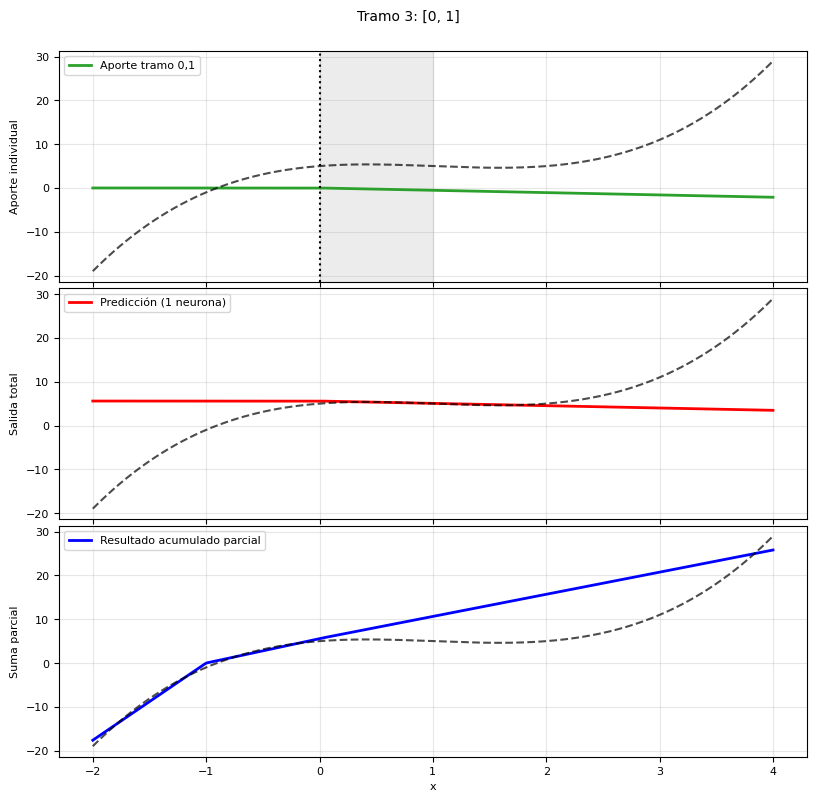

Tramo 3 [0,1] — w entrenado = -0.5297
Altura final del tramo: 5.0528



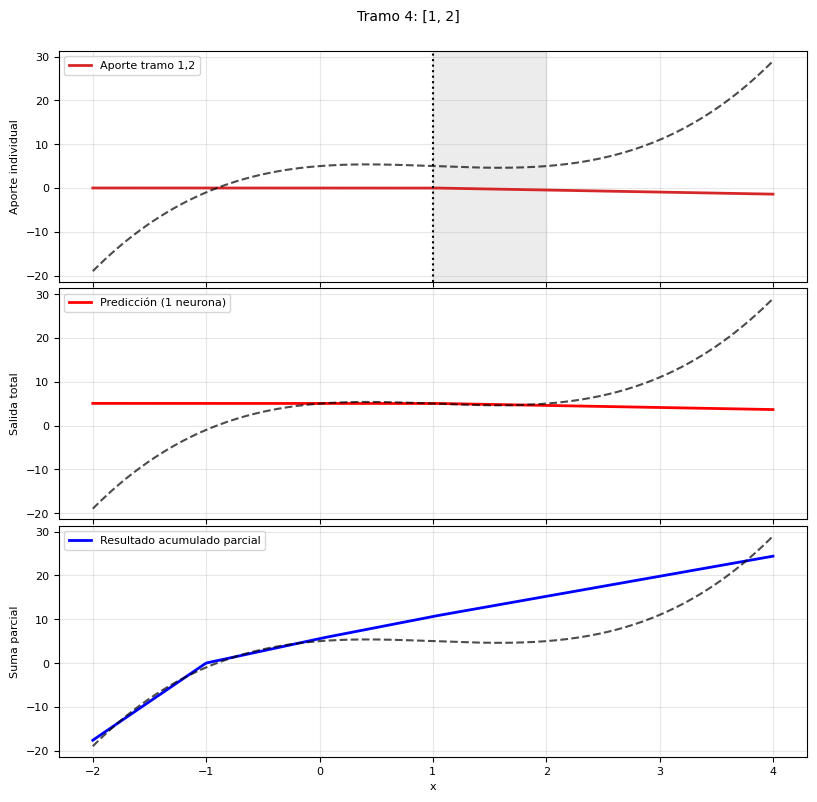

Tramo 4 [1,2] — w entrenado = -0.4697
Altura final del tramo: 4.5832



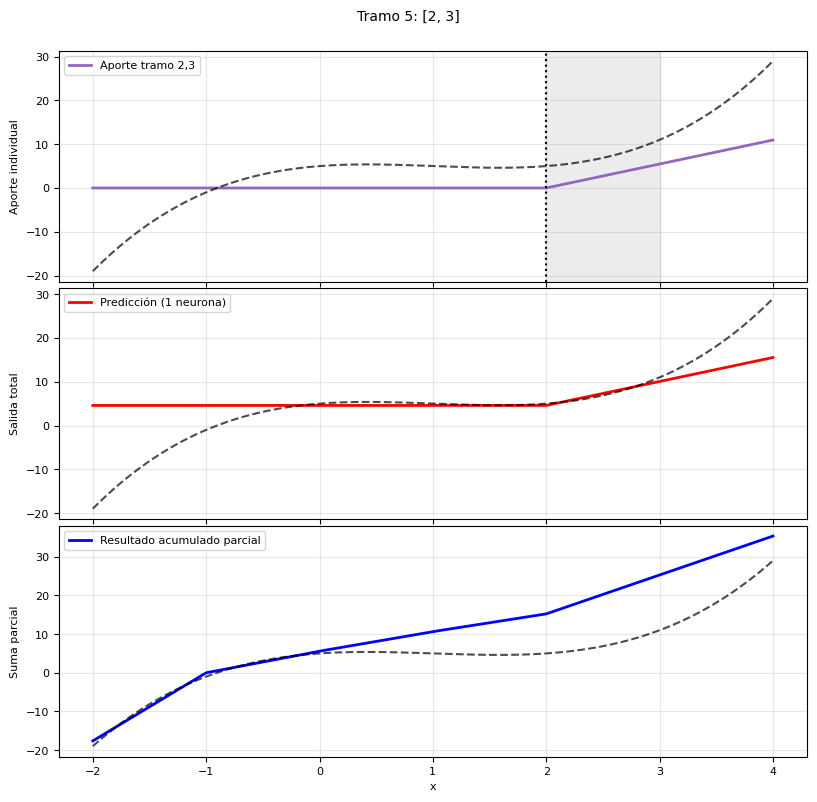

Tramo 5 [2,3] — w entrenado = 5.4751
Altura final del tramo: 10.0994



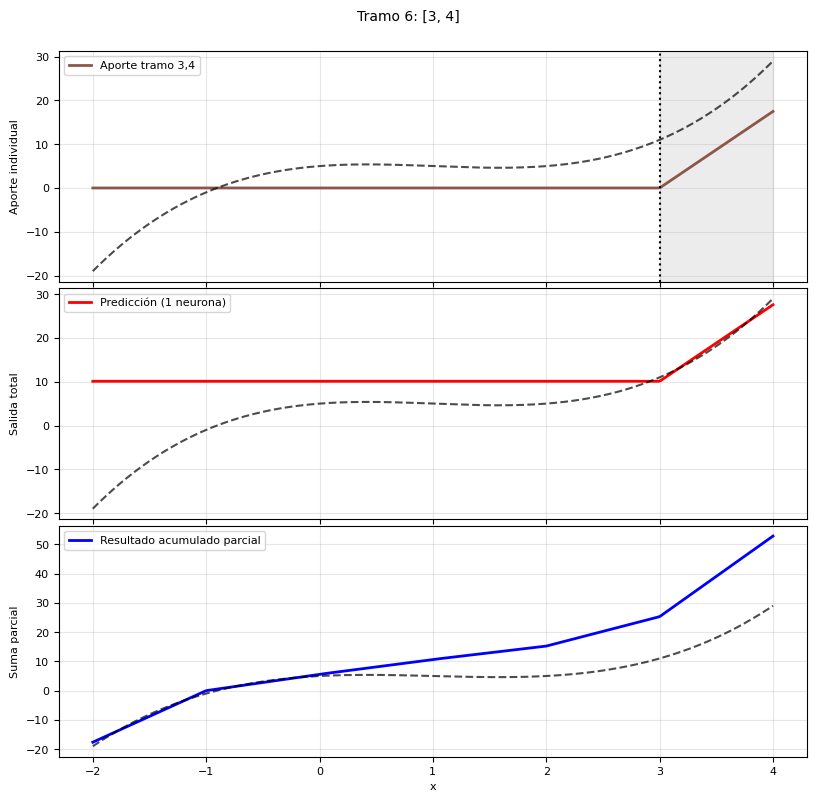

Tramo 6 [3,4] — w entrenado = 17.4835
Altura final del tramo: 27.5828



In [157]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ==== Datos (dominio global) ====
x_min, x_max = -2, 4
x = np.linspace(x_min, x_max, 400)
f = x**3 - 3*x**2 + 2*x + 5

x_tensor_full = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
f_tensor_full = torch.tensor(f, dtype=torch.float32).unsqueeze(1)

# ==== Modelo (una sola neurona, break fijo, pendiente interna fija) ====
class FixedBreakReLU(nn.Module):
    def __init__(self, fixed_break, activate_left=False, y_offset=0.0):
        super().__init__()
        self.register_buffer("x_star", torch.tensor([[fixed_break]], dtype=torch.float32))
        self.w = nn.Parameter(torch.tensor([[0.1]], dtype=torch.float32))  # único parámetro entrenable
        self.y_offset = y_offset
        self.activate_left = activate_left
        self.slope = 1.0  # pendiente interna fija

    def forward(self, x):
        if self.activate_left:
            z = torch.relu(-self.slope * x.T + self.slope * self.x_star)
        else:
            b = -self.slope * self.x_star
            z = torch.relu(self.slope * x.T + b)
        out = (self.w.T @ z).T + self.y_offset
        return out, z

# ==== Lista de tramos ====
segments = [(-2, -1), (-1, 0), (0, 1), (1, 2), (2, 3), (3, 4)]

# ==== Entrenamiento por tramo ====
prev_y_at_right = 0.0
y_accum = np.zeros_like(x)

for i, (seg_left, seg_right) in enumerate(segments):
    mask_local = (x >= seg_left) & (x <= seg_right)
    x_local = x[mask_local]
    f_local = f[mask_local]
    x_tensor_local = torch.tensor(x_local, dtype=torch.float32).unsqueeze(1)
    f_tensor_local = torch.tensor(f_local, dtype=torch.float32).unsqueeze(1)

    # ==== Configuración del break ====
    if i == 0:
        fixed_break = seg_right
        activate_left = True
    else:
        fixed_break = seg_left
        activate_left = False

    model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=prev_y_at_right)
    optimizer = optim.Adam([model.w], lr=0.05)  # solo w se entrena
    loss_fn = nn.MSELoss()

    # ==== Entrenamiento ====
    for epoch in range(3000):
        optimizer.zero_grad()
        out_local, _ = model(x_tensor_local)
        loss = loss_fn(out_local, f_tensor_local)
        loss.backward()
        optimizer.step()

    # ==== Evaluación ====
    with torch.no_grad():
        out_full, z_full = model(x_tensor_full)
        contrib = (model.w * z_full).squeeze().numpy()
        y_pred_full = out_full.squeeze().numpy()
        idx_right = np.argmin(np.abs(x - seg_right))
        prev_y_at_right = y_pred_full[idx_right]

    # ==== Acumulado parcial ====
    y_accum += contrib

    # ==== Gráficas ====
    fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

    axes[0].plot(x, contrib, color=f'C{i}', lw=2, label=f'Aporte tramo {seg_left},{seg_right}')
    axes[0].axvspan(seg_left, seg_right, color='gray', alpha=0.15)
    axes[0].axvline(fixed_break, color='k', linestyle=':')
    axes[0].plot(x, f, 'k--', alpha=0.7)
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3)
    axes[0].set_ylabel('Aporte individual')

    axes[1].plot(x, y_pred_full, 'r', lw=2, label='Predicción (1 neurona)')
    axes[1].plot(x, f, 'k--', alpha=0.7)
    axes[1].legend(fontsize=8)
    axes[1].grid(alpha=0.3)
    axes[1].set_ylabel('Salida total')

    axes[2].plot(x, y_accum, 'b', lw=2, label='Resultado acumulado parcial')
    axes[2].plot(x, f, 'k--', alpha=0.7)
    axes[2].legend(fontsize=8)
    axes[2].grid(alpha=0.3)
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('Suma parcial')

    plt.suptitle(f"Tramo {i+1}: [{seg_left}, {seg_right}]", fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"Tramo {i+1} [{seg_left},{seg_right}] — w entrenado = {model.w.item():.4f}")
    print(f"Altura final del tramo: {prev_y_at_right:.4f}\n")


Tramos generados: [(-2, -1.5), (-1.5, -1.0), (-1.0, -0.5), (-0.5, 0.0), (0.0, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0)]


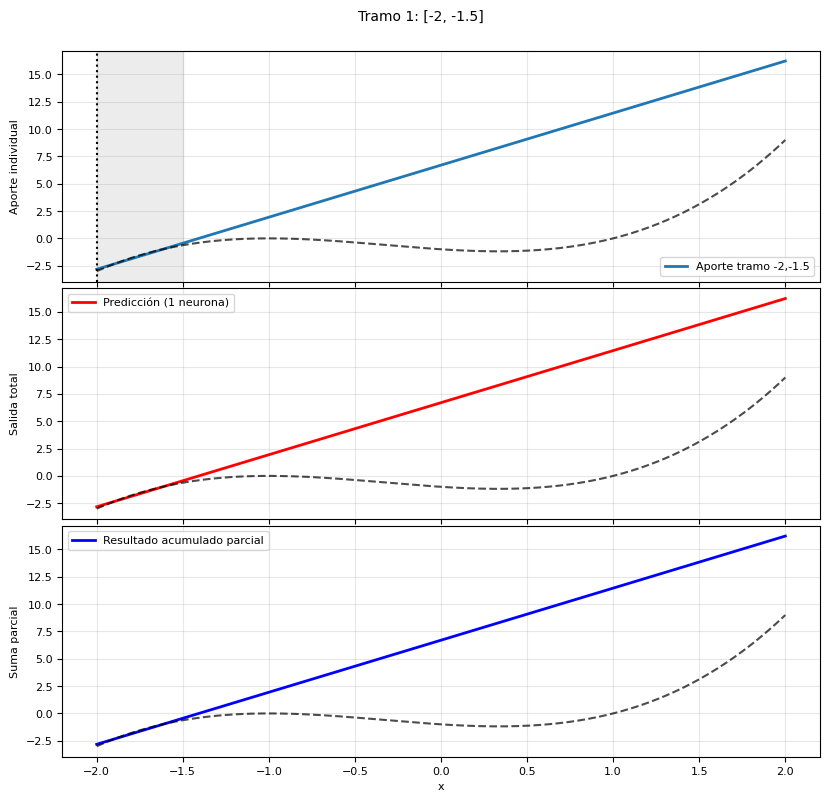

Tramo 1 [-2,-1.5] — w entrenado = 4.7625
y_offset optimizado = -2.8265
Altura final: -0.4393, Pendiente acumulada: 4.7625



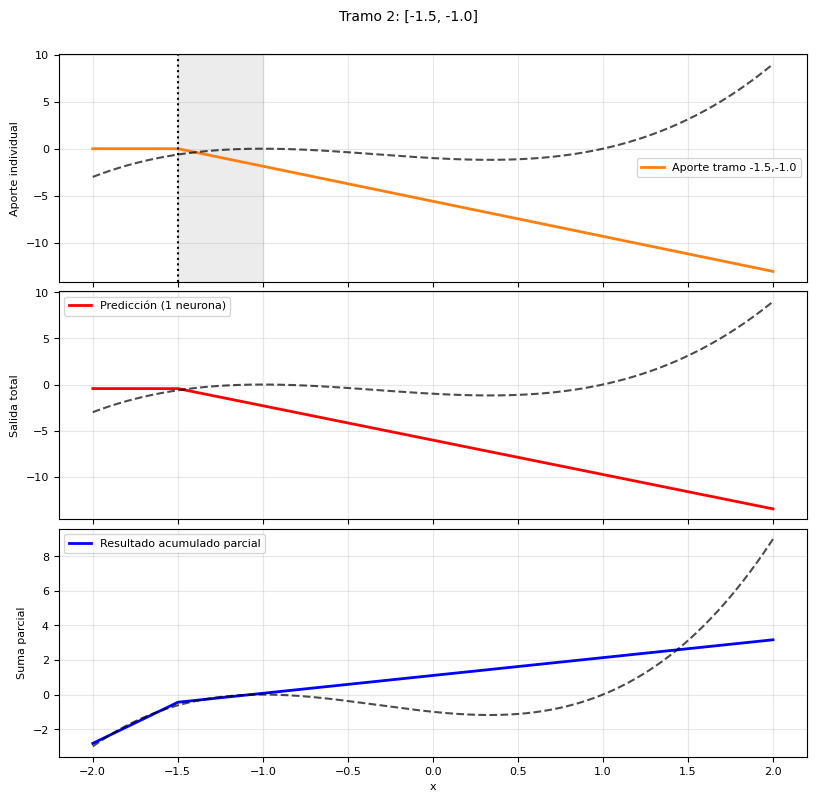

Tramo 2 [-1.5,-1.0] — w entrenado = -3.7299
Altura final: 0.0737, Pendiente acumulada: 1.0326



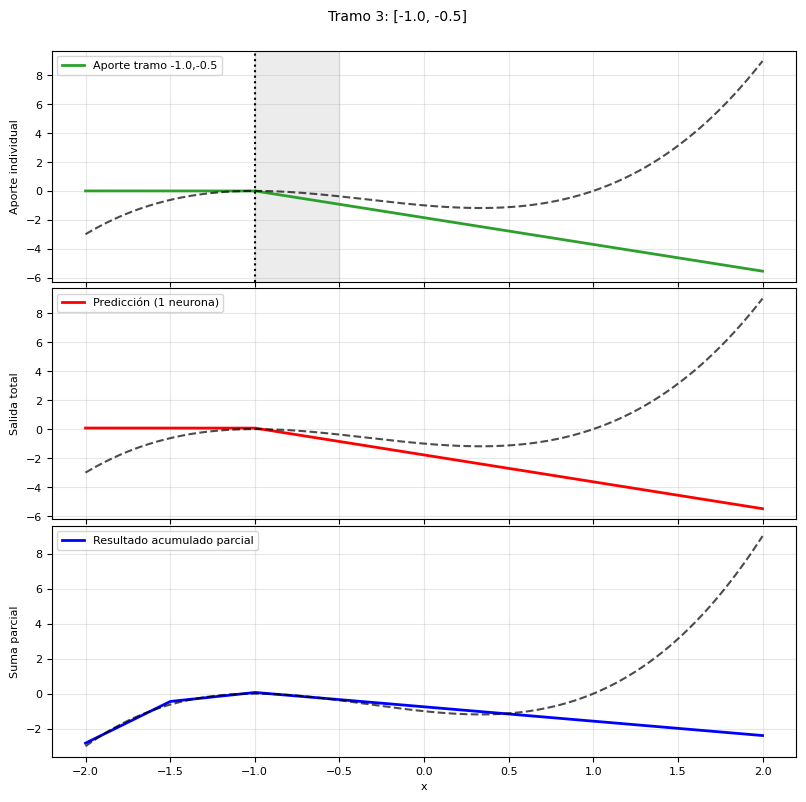

Tramo 3 [-1.0,-0.5] — w entrenado = -1.8531
Altura final: -0.3422, Pendiente acumulada: -0.8204



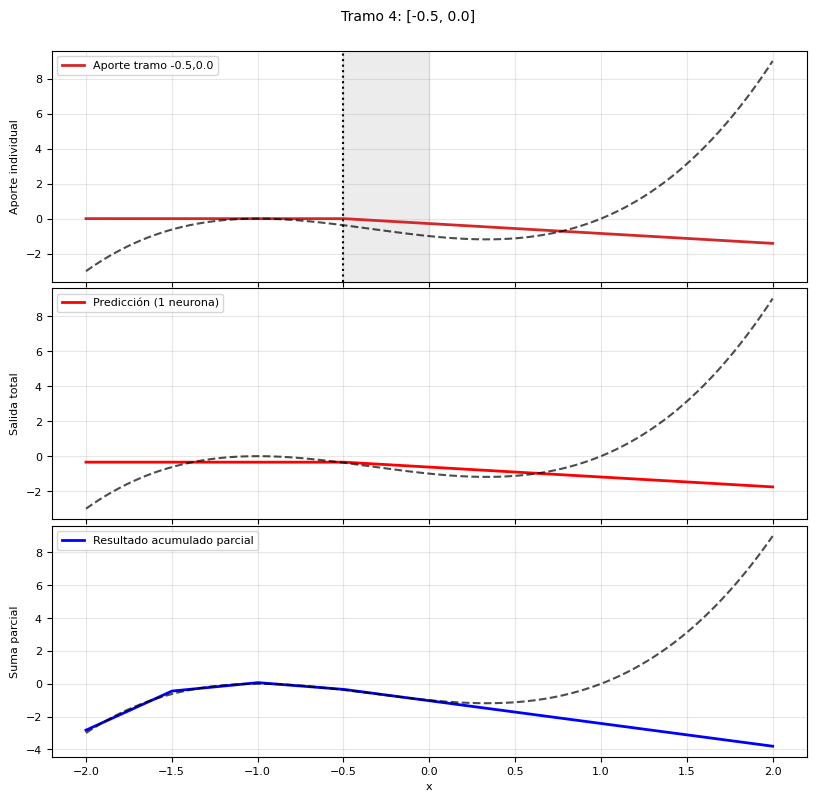

Tramo 4 [-0.5,0.0] — w entrenado = -0.5655
Altura final: -1.0390, Pendiente acumulada: -1.3859



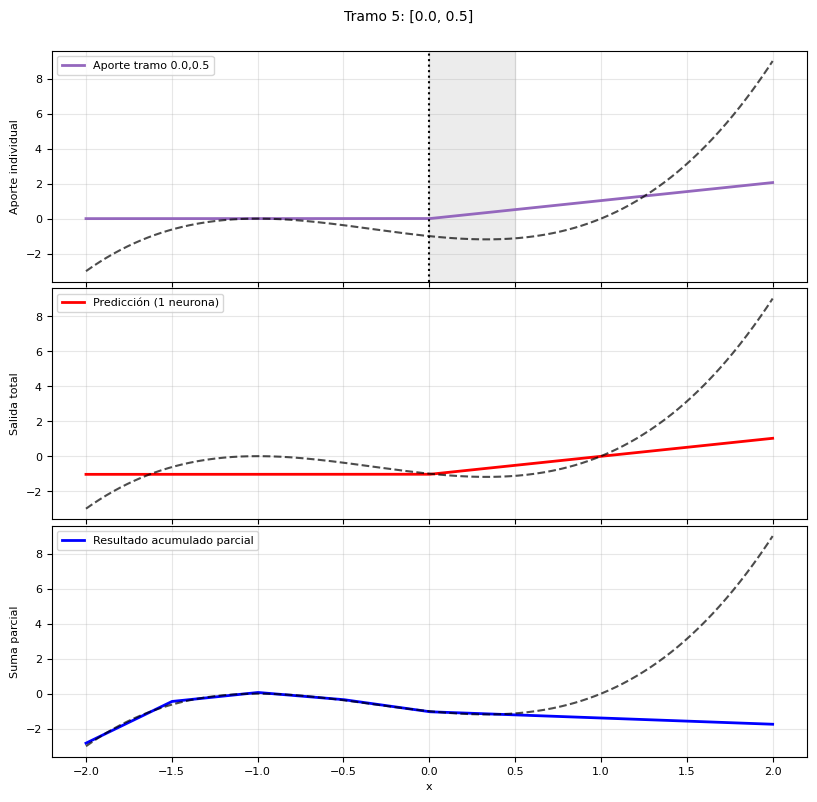

Tramo 5 [0.0,0.5] — w entrenado = 1.0293
Altura final: -1.2090, Pendiente acumulada: -0.3566



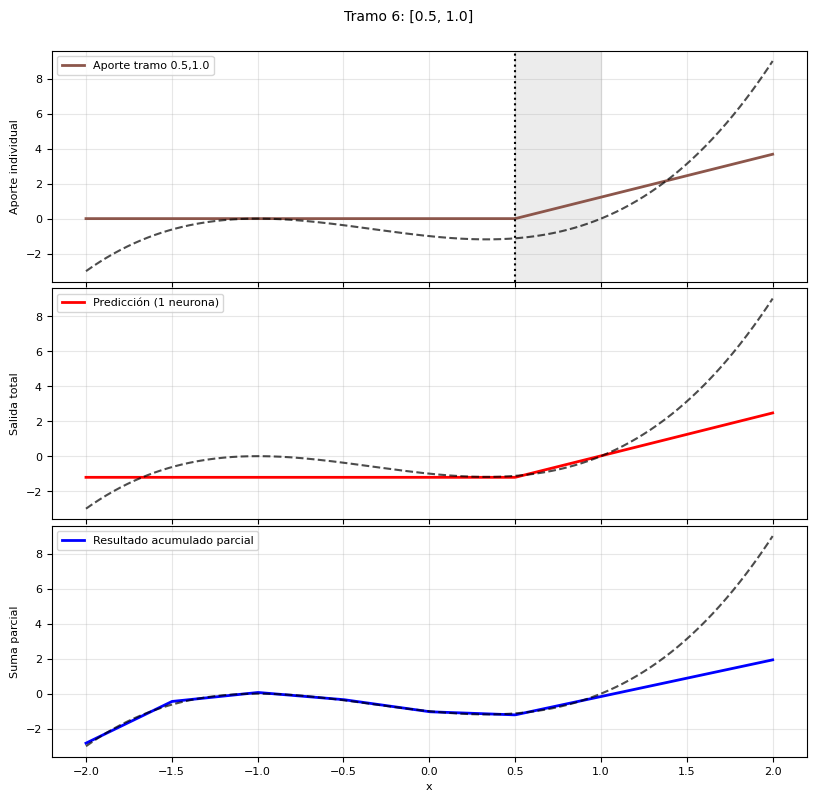

Tramo 6 [0.5,1.0] — w entrenado = 2.4510
Altura final: -0.1684, Pendiente acumulada: 2.0944



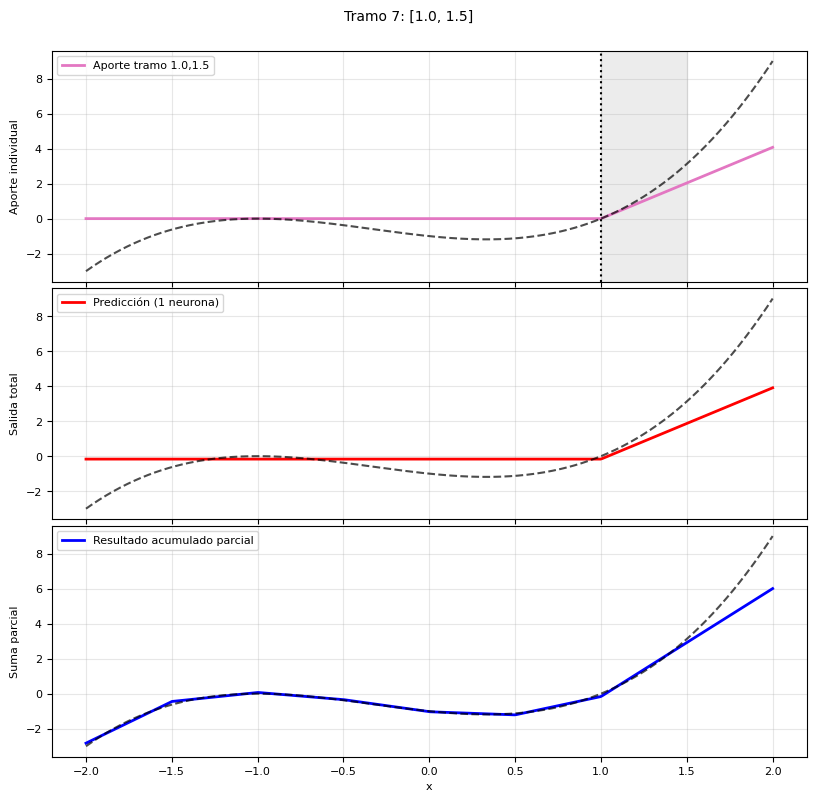

Tramo 7 [1.0,1.5] — w entrenado = 4.0704
Altura final: 2.9115, Pendiente acumulada: 6.1648



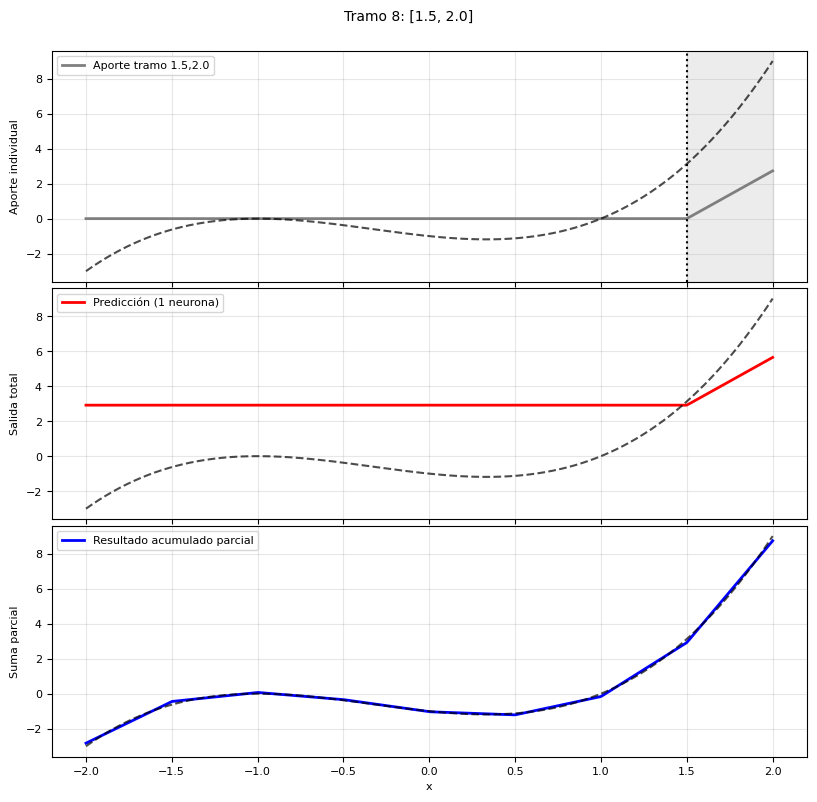

Tramo 8 [1.5,2.0] — w entrenado = 5.4552
Altura final: 8.7293, Pendiente acumulada: 11.6200



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ==== Datos (dominio global) ====
x_min, x_max = -2, 2
x = np.linspace(x_min, x_max, 400)
f = x**3 - 3*x**2 + 2*x + 5
f = x**3 + x**2 - x - 1


x_tensor_full = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
f_tensor_full = torch.tensor(f, dtype=torch.float32).unsqueeze(1)

# ==== Modelo (una sola neurona, pendiente w entrenable) ====
class FixedBreakReLU(nn.Module):
    def __init__(self, fixed_break, activate_left=False, y_offset=0.0):
        super().__init__()
        self.register_buffer("x_star", torch.tensor([[fixed_break]], dtype=torch.float32))
        self.w = nn.Parameter(torch.tensor([[0.1]], dtype=torch.float32))  # pendiente entrenable
        self.y_offset = y_offset
        self.activate_left = activate_left

    def forward(self, x):
        if self.activate_left:
            # ReLU activada hacia la izquierda del break
            z = torch.relu(self.x_star - x.T)
        else:
            # ReLU activada hacia la derecha del break
            z = torch.relu(x.T - self.x_star)
        out = (self.w.T @ z).T + self.y_offset
        return out, z

# ==== Lista de tramos automática ====
step = 0.5  # tamaño de cada tramo
segments = []
curr = x_min
while curr < x_max:
    segments.append((curr, min(curr + step, x_max)))
    curr += step
print("Tramos generados:", segments)

# ==== Entrenamiento por tramo ====
prev_y_at_right = 0.0
y_accum = np.zeros_like(x)
prev_slope_accum = 0.0  # pendiente acumulada hasta el tramo anterior

for i, (seg_left, seg_right) in enumerate(segments):
    mask_local = (x >= seg_left) & (x <= seg_right)
    x_local = x[mask_local]
    f_local = f[mask_local]
    x_tensor_local = torch.tensor(x_local, dtype=torch.float32).unsqueeze(1)
    f_tensor_local = torch.tensor(f_local, dtype=torch.float32).unsqueeze(1)

    # ==== Configuración del break y offset ====
    if i == 0:
        # Primer tramo: activación hacia la derecha, offset entrenable
        fixed_break = seg_left
        activate_left = False
        model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=0.0)
        model.y_offset = nn.Parameter(torch.tensor([[0.0]], dtype=torch.float32))
        optimizer = optim.Adam([model.w, model.y_offset], lr=0.05)
    else:
        # Tramos siguientes: activación hacia la derecha, offset fijo
        fixed_break = seg_left
        activate_left = False
        model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=prev_y_at_right)
        optimizer = optim.Adam([model.w], lr=0.05)

    loss_fn = nn.MSELoss()

    # ==== Entrenamiento ====
    for epoch in range(3000):
        optimizer.zero_grad()
        out_local, _ = model(x_tensor_local)
        target_corr = f_tensor_local - prev_slope_accum * (x_tensor_local - seg_left)
        loss = loss_fn(out_local, target_corr)
        loss.backward()
        optimizer.step()

    # ==== Evaluación ====
    with torch.no_grad():
        out_full, z_full = model(x_tensor_full)
        contrib = (model.w * z_full).squeeze().numpy()
        if i == 0:
            # incluir el offset entrenado para la primera neurona
            contrib += model.y_offset.item()
        y_pred_full = out_full.squeeze().numpy()
        idx_right = np.argmin(np.abs(x - seg_right))
        prev_y_at_right = y_pred_full[idx_right]

        # Actualizar pendiente acumulada
        slope = model.w.item()
        prev_slope_accum += slope

    # Actualizar salida acumulada total
    y_accum += contrib
    prev_y_at_right = y_accum[idx_right]

    # ==== Graficar ====
    fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

    axes[0].plot(x, contrib, color=f'C{i}', lw=2, label=f'Aporte tramo {seg_left},{seg_right}')
    axes[0].axvspan(seg_left, seg_right, color='gray', alpha=0.15)
    axes[0].axvline(fixed_break, color='k', linestyle=':')
    axes[0].plot(x, f, 'k--', alpha=0.7)
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3)
    axes[0].set_ylabel('Aporte individual')

    axes[1].plot(x, y_pred_full, 'r', lw=2, label='Predicción (1 neurona)')
    axes[1].plot(x, f, 'k--', alpha=0.7)
    axes[1].legend(fontsize=8)
    axes[1].grid(alpha=0.3)
    axes[1].set_ylabel('Salida total')

    axes[2].plot(x, y_accum, 'b', lw=2, label='Resultado acumulado parcial')
    axes[2].plot(x, f, 'k--', alpha=0.7)
    axes[2].legend(fontsize=8)
    axes[2].grid(alpha=0.3)
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('Suma parcial')

    plt.suptitle(f"Tramo {i+1}: [{seg_left}, {seg_right}]", fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"Tramo {i+1} [{seg_left},{seg_right}] — w entrenado = {model.w.item():.4f}")
    if i == 0:
        print(f"y_offset optimizado = {model.y_offset.item():.4f}")
    print(f"Altura final: {prev_y_at_right:.4f}, Pendiente acumulada: {prev_slope_accum:.4f}\n")


Tramos generados: [(-2, -1.5), (-1.5, -1.0), (-1.0, -0.5), (-0.5, 0.0), (0.0, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0)]


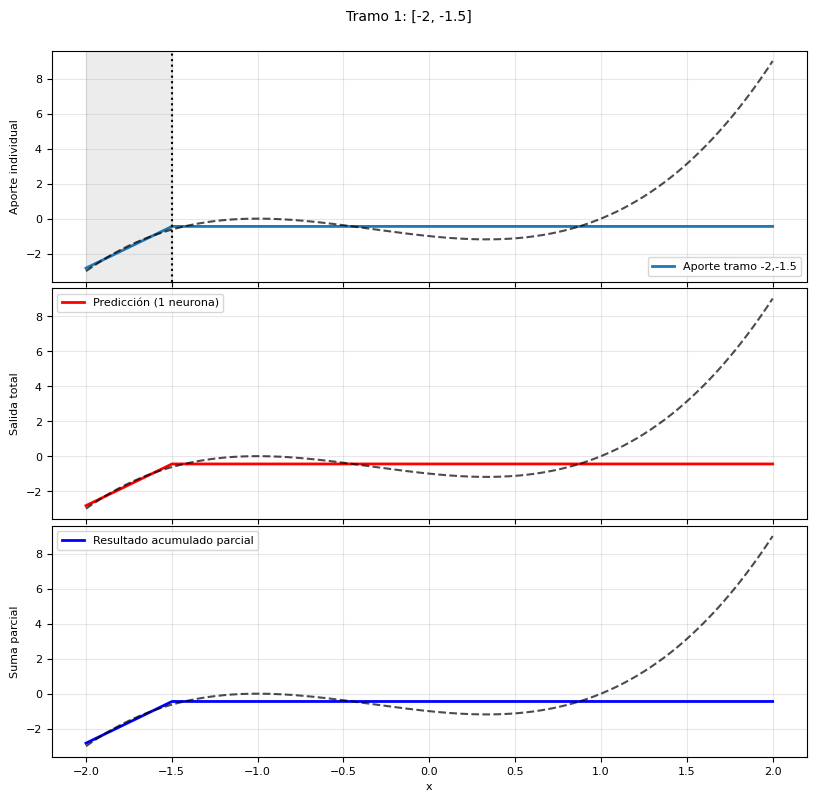

Tramo 1 [-2,-1.5] — w entrenado = -4.7625
y_offset optimizado = -0.4452
Altura final: -0.4452, Pendiente acumulada: 0.0000



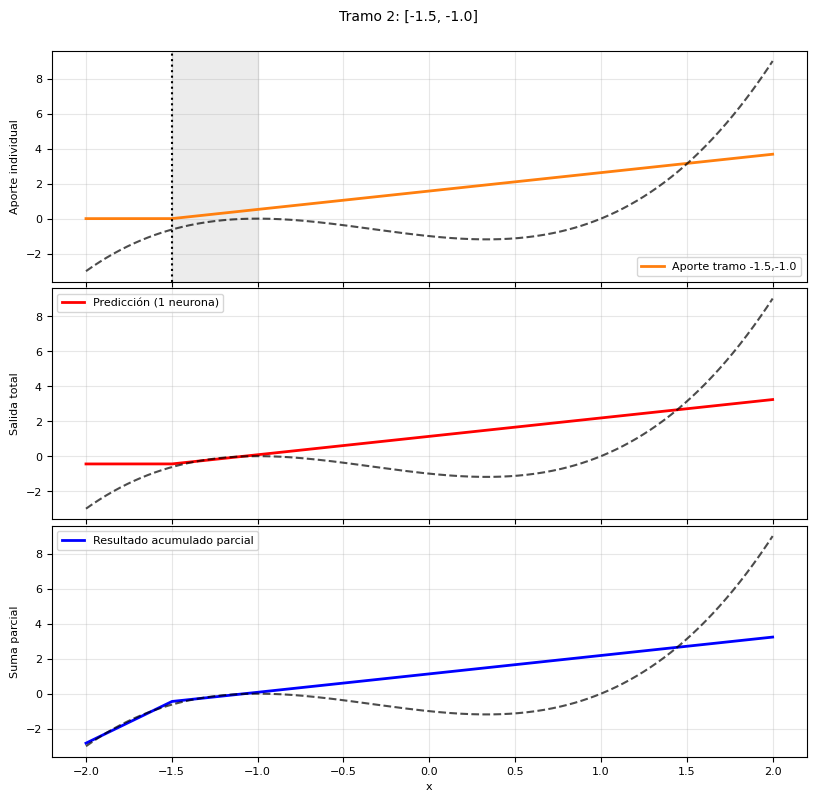

Tramo 2 [-1.5,-1.0] — w entrenado = 1.0506
Altura final: 0.0827, Pendiente acumulada: 1.0506



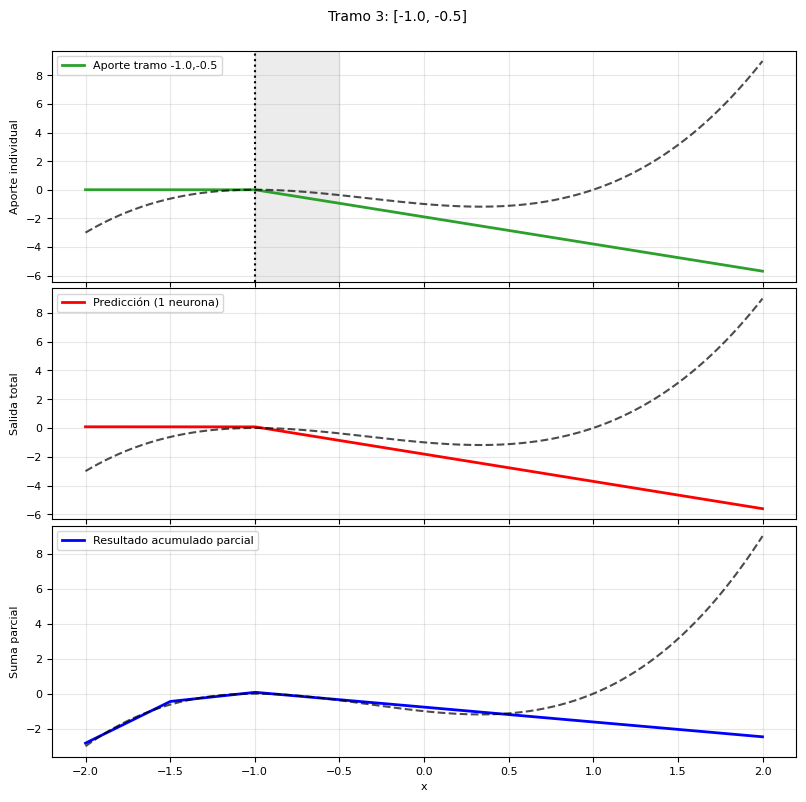

Tramo 3 [-1.0,-0.5] — w entrenado = -1.8983
Altura final: -0.3469, Pendiente acumulada: -0.8476



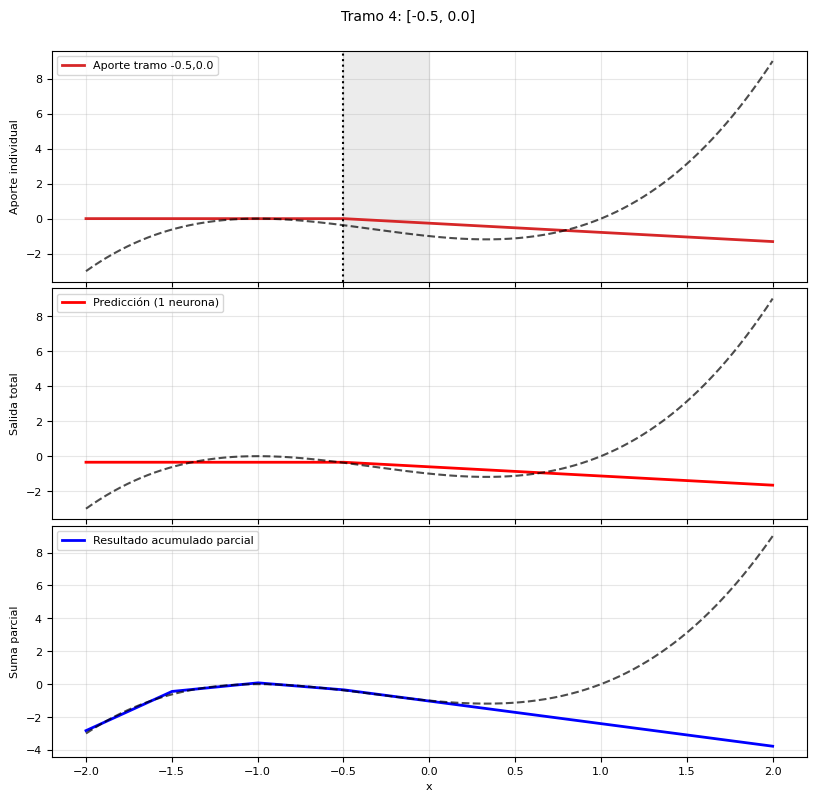

Tramo 4 [-0.5,0.0] — w entrenado = -0.5242
Altura final: -1.0365, Pendiente acumulada: -1.3718



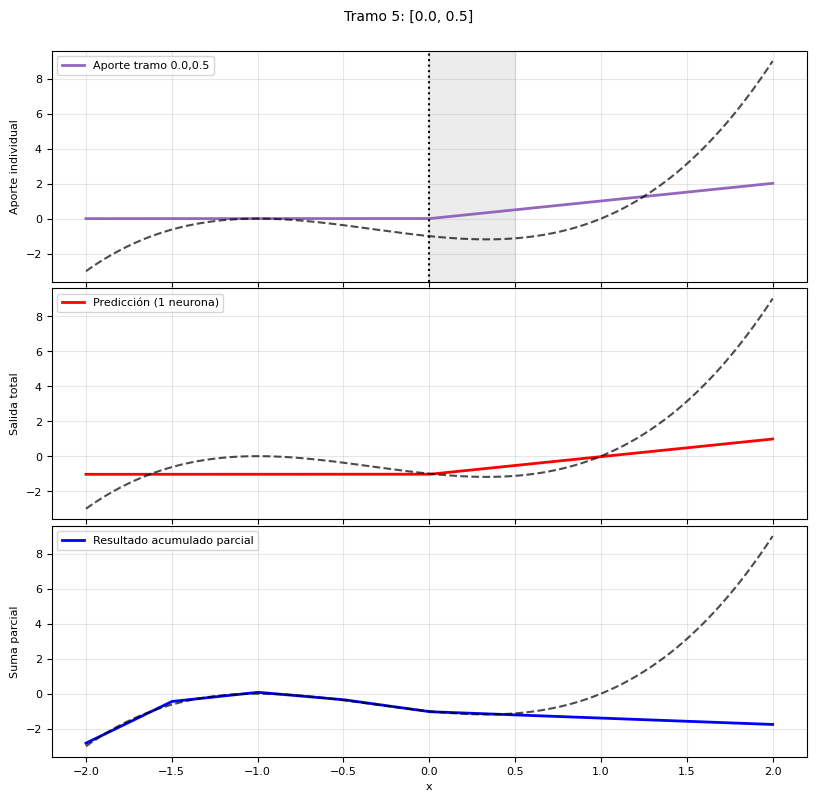

Tramo 5 [0.0,0.5] — w entrenado = 1.0076
Altura final: -1.2103, Pendiente acumulada: -0.3642



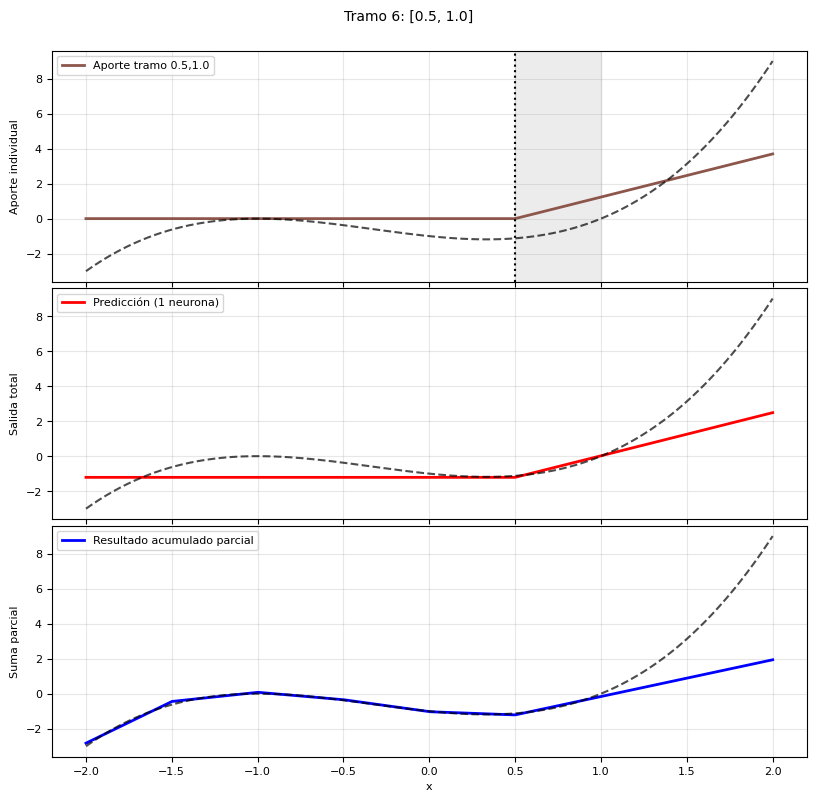

Tramo 6 [0.5,1.0] — w entrenado = 2.4625
Altura final: -0.1678, Pendiente acumulada: 2.0983



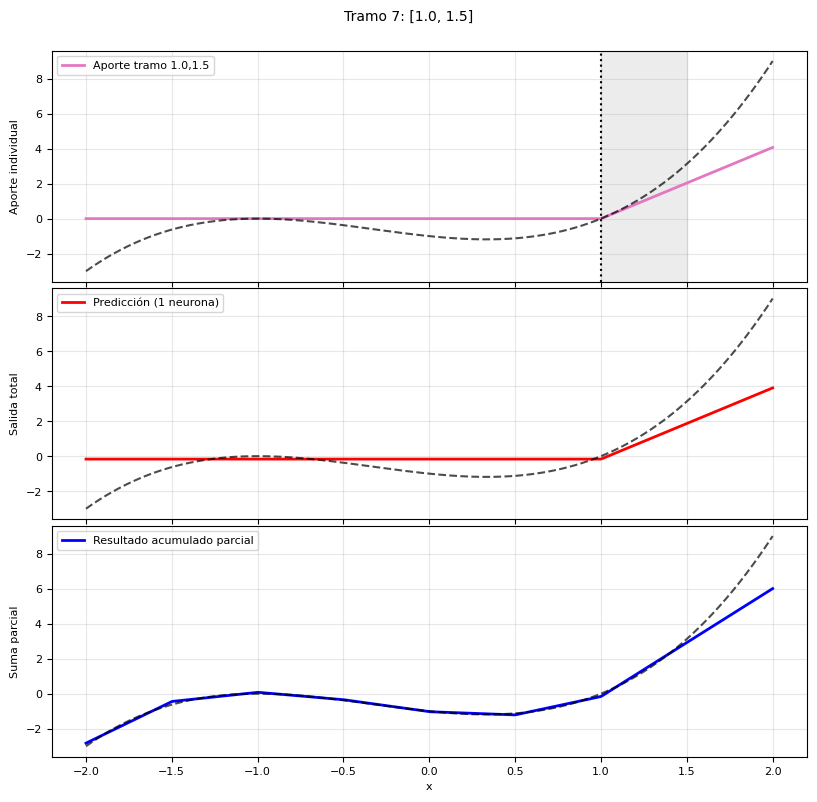

Tramo 7 [1.0,1.5] — w entrenado = 4.0647
Altura final: 2.9113, Pendiente acumulada: 6.1630



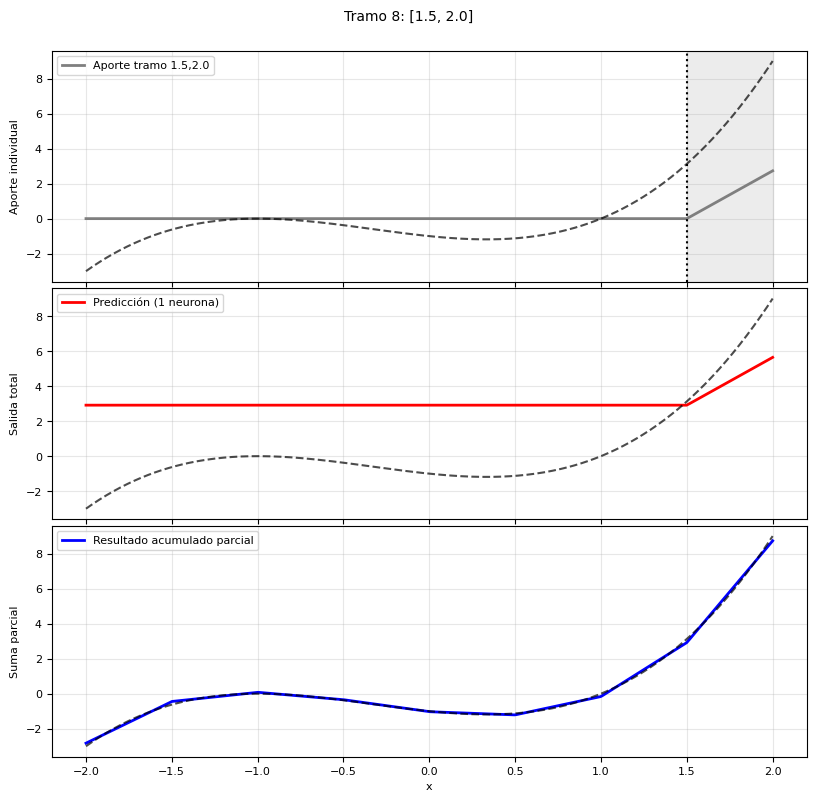

Tramo 8 [1.5,2.0] — w entrenado = 5.4578
Altura final: 8.7294, Pendiente acumulada: 11.6209



In [205]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ==== Datos (dominio global) ====
x_min, x_max = -2, 2
x = np.linspace(x_min, x_max, 400)
f = x**3 - 3*x**2 + 2*x + 5
f = x**3 + x**2 - x - 1


x_tensor_full = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
f_tensor_full = torch.tensor(f, dtype=torch.float32).unsqueeze(1)

# ==== Modelo (una sola neurona, pendiente w entrenable) ====
class FixedBreakReLU(nn.Module):
    def __init__(self, fixed_break, activate_left=False, y_offset=0.0):
        super().__init__()
        self.register_buffer("x_star", torch.tensor([[fixed_break]], dtype=torch.float32))
        self.w = nn.Parameter(torch.tensor([[0.1]], dtype=torch.float32))  # pendiente entrenable
        self.y_offset = y_offset
        self.activate_left = activate_left

    def forward(self, x):
        if self.activate_left:
            # ReLU activada hacia la izquierda del break
            z = torch.relu(self.x_star - x.T)
        else:
            # ReLU activada hacia la derecha del break
            z = torch.relu(x.T - self.x_star)
        out = (self.w.T @ z).T + self.y_offset
        return out, z

# ==== Lista de tramos automática ====
step = 0.5  # tamaño de cada tramo
segments = []
curr = x_min
while curr < x_max:
    segments.append((curr, min(curr + step, x_max)))
    curr += step
print("Tramos generados:", segments)

# ==== Entrenamiento por tramo ====
prev_y_at_right = 0.0
y_accum = np.zeros_like(x)
prev_slope_accum = 0.0  # pendiente acumulada hasta el tramo anterior

for i, (seg_left, seg_right) in enumerate(segments):
    mask_local = (x >= seg_left) & (x <= seg_right)
    x_local = x[mask_local]
    f_local = f[mask_local]
    x_tensor_local = torch.tensor(x_local, dtype=torch.float32).unsqueeze(1)
    f_tensor_local = torch.tensor(f_local, dtype=torch.float32).unsqueeze(1)

    # ==== Configuración del break y offset ====
    if i == 0:
        # Primer tramo: activación hacia la derecha, offset entrenable
        fixed_break = seg_right
        activate_left = True
        model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=0.0)
        model.y_offset = nn.Parameter(torch.tensor([[0.0]], dtype=torch.float32))
        optimizer = optim.Adam([model.w, model.y_offset], lr=0.05)
    else:
        # Tramos siguientes: activación hacia la derecha, offset fijo
        fixed_break = seg_left
        activate_left = False
        model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=prev_y_at_right)
        optimizer = optim.Adam([model.w], lr=0.05)

    loss_fn = nn.MSELoss()

    # ==== Entrenamiento ====
    for epoch in range(3000):
        optimizer.zero_grad()
        out_local, _ = model(x_tensor_local)
        target_corr = f_tensor_local - prev_slope_accum * (x_tensor_local - seg_left)
        loss = loss_fn(out_local, target_corr)
        loss.backward()
        optimizer.step()

    # ==== Evaluación ====
    with torch.no_grad():
        out_full, z_full = model(x_tensor_full)
        contrib = (model.w * z_full).squeeze().numpy()
        if i == 0:
            # incluir el offset entrenado para la primera neurona
            contrib += model.y_offset.item()
        y_pred_full = out_full.squeeze().numpy()
        idx_right = np.argmin(np.abs(x - seg_right))
        prev_y_at_right = y_pred_full[idx_right]

        # Actualizar pendiente acumulada
        slope = model.w.item()
        if i==0 and activate_left:
            slope = 0  # invertir signo si es el primer tramo y activa a la izquierda
        prev_slope_accum += slope

    # Actualizar salida acumulada total
    y_accum += contrib
    prev_y_at_right = y_accum[idx_right]

    # ==== Graficar ====
    fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

    axes[0].plot(x, contrib, color=f'C{i}', lw=2, label=f'Aporte tramo {seg_left},{seg_right}')
    axes[0].axvspan(seg_left, seg_right, color='gray', alpha=0.15)
    axes[0].axvline(fixed_break, color='k', linestyle=':')
    axes[0].plot(x, f, 'k--', alpha=0.7)
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3)
    axes[0].set_ylabel('Aporte individual')

    axes[1].plot(x, y_pred_full, 'r', lw=2, label='Predicción (1 neurona)')
    axes[1].plot(x, f, 'k--', alpha=0.7)
    axes[1].legend(fontsize=8)
    axes[1].grid(alpha=0.3)
    axes[1].set_ylabel('Salida total')

    axes[2].plot(x, y_accum, 'b', lw=2, label='Resultado acumulado parcial')
    axes[2].plot(x, f, 'k--', alpha=0.7)
    axes[2].legend(fontsize=8)
    axes[2].grid(alpha=0.3)
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('Suma parcial')

    plt.suptitle(f"Tramo {i+1}: [{seg_left}, {seg_right}]", fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"Tramo {i+1} [{seg_left},{seg_right}] — w entrenado = {model.w.item():.4f}")
    if i == 0:
        print(f"y_offset optimizado = {model.y_offset.item():.4f}")
    print(f"Altura final: {prev_y_at_right:.4f}, Pendiente acumulada: {prev_slope_accum:.4f}\n")
